In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data imports
from sqlalchemy import create_engine

# Model preprocessing and processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Performance evaluation
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix

# Visual options
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200


# Global constants
NOT_APLIC_STR = "NA_SS"
NOT_APLIC_NUM = -999.0
RANDOM_STATE = 2021
DAYS_PER_YEAR = 365.2425

In [2]:
# IMPORT PROTESTS DATASET
engine = create_engine('sqlite:///../data/processed/protests.db')
with engine.begin() as connection:
    df_protests = pd.read_sql('SELECT * FROM protests', con=connection)
    
df_protests.startdate = pd.to_datetime(df_protests.startdate)
df_protests.enddate = pd.to_datetime(df_protests.enddate)

In [3]:
# IMPORT GOVERNMENTS DATASET
engine = create_engine('sqlite:///../data/processed/governments.db')
with engine.begin() as connection:
    df_govts = pd.read_sql('SELECT * FROM governments', con=connection)

df_govts.index = df_govts.year_scode
df_govts.drop('year_scode', axis=1, inplace=True)

In [4]:
# IMPORT REGIME CHANGE DATASET
engine = create_engine('sqlite:///../data/processed/regime_changes.db')
with engine.begin() as connection:
    df_regimes = pd.read_sql('SELECT * FROM regime_changes', con=connection)
    
# Type conversions
df_regimes.startdate = pd.to_datetime(df_regimes.startdate)
df_regimes.enddate = pd.to_datetime(df_regimes.enddate)
df_regimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country       1290 non-null   object        
 1   scode         1290 non-null   object        
 2   startdate     1290 non-null   datetime64[ns]
 3   enddate       1290 non-null   datetime64[ns]
 4   duration_yrs  1290 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 50.5+ KB


In [5]:
# Join both dataframes
df = df_protests.join(df_govts, how='left', on='year_scode')

# Remove entries that don't have corresponding 'government' data
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15064 entries, 0 to 15207
Data columns (total 85 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   protest_id                          15064 non-null  int64         
 1   country                             15064 non-null  object        
 2   scode                               15064 non-null  object        
 3   region                              15064 non-null  object        
 4   protestnumber                       15064 non-null  int64         
 5   protesterviolence                   15064 non-null  int64         
 6   protesteridentity                   15064 non-null  object        
 7   startdate                           15064 non-null  datetime64[ns]
 8   enddate                             15064 non-null  datetime64[ns]
 9   duration_days                       15064 non-null  int64         
 10  participants          

In [6]:
# BASIC QC THAT NAMES & IDs MATCH
missing_countries = df.loc[(df.country != df.country_govt)][['scode', 'scode_govt', 'country', 'country_govt']]
missing_countries = missing_countries.drop_duplicates()
display(missing_countries.sort_values(by='scode'))

# These countries do not contain government data. Remove. 
scodes_to_remove = missing_countries.scode.unique()
scodes_to_remove_ind = [x in scodes_to_remove for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

,scode,scode_govt,country,country_govt


In [7]:
all_countries = df.scode.unique()
regime_countries = df_regimes.scode.unique()

missing = []
for country in all_countries:
    if country not in regime_countries:
        missing.append(country)

print('Countries missing from "Regimes" dataset:', missing)

# Remove these countries from dataset
scodes_to_remove_ind = [x in missing for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

Countries missing from "Regimes" dataset: ['LUX']


## Engineer new target

Game plan:
- Create column for "next regime change date"
- Create column for "days until next regime change"
- Create target column for [above column] < 365 (try for other targets too)

In [8]:
# USE THIS STRUCTURE TO LOOP OVER EACH COUNTRY, SIMILAR TO HOW ENDDATE WAS QC'D
# Loop over all country names
working_df = df[['scode', 'startdate']].copy()
working_df['next_regime_chg_date'] = None
working_df['days_until_next_regime_chg'] = None
working_df['target (<365)'] = None

for protest_index, protest_scode, protest_start in df.reset_index()[['index', 'scode', 'startdate']].values:
    
    # look only at country in question
    regime_country_df = df_regimes.loc[df_regimes.scode==protest_scode]
       
    
    
#     #TESTING ONLY
#     if protest_index == 7289:
#             print('protest start:', protest_start)
    
    # Loop over all regime indices
    for regime_index in regime_country_df.index:
        # isolate startdate and enddate for selected regime
        regime_start = regime_country_df.loc[regime_index, 'startdate']
        regime_end   = regime_country_df.loc[regime_index, 'enddate']
        
        
        # if protest occurs before statehood,set the 'regime end' to the date it became a state 
        # this would correspond to protests about creating a state. Note that this is very rare in this dataset
        if (regime_index == regime_country_df.index[0]) and (protest_start < regime_start):
            working_df.loc[protest_index, 'next_regime_chg_date'] = regime_start
        

        
#         #TESTING ONLY
#         elif protest_index == 7289:
#             print('regime start / end:', regime_start, '|', regime_end)
        
        # test if the protest is within selected regime row
        elif (protest_start >= regime_start) and (protest_start <= regime_end):
            working_df.loc[protest_index, 'next_regime_chg_date'] = regime_end
    if working_df.loc[protest_index, 'next_regime_chg_date'] == None:
        print('broke')
        break

    
# # Convert from 'object' to 'datetime' format
working_df['next_regime_chg_date'] = pd.to_datetime(working_df['next_regime_chg_date'])


# # Incorporate new column for "duration"
working_df['days_until_next_regime_chg'] = (working_df['next_regime_chg_date'] - working_df['startdate']).dt.days

working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15061 entries, 0 to 15207
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   scode                       15061 non-null  object        
 1   startdate                   15061 non-null  datetime64[ns]
 2   next_regime_chg_date        15061 non-null  datetime64[ns]
 3   days_until_next_regime_chg  15061 non-null  int64         
 4   target (<365)               0 non-null      object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 1.2+ MB


#### Combine this data with main df

In [9]:
df['days_until_next_regime_chg'] = working_df['days_until_next_regime_chg']

## Basic cleaning

In [10]:
# Add 'startyear' in numeric format to replace datetime format since models can't handle the latter
df['startyear'] = df.startdate.dt.year

In [11]:
# Relace 'placeholder' NaN values, as defined by data dictionary (see raw data directory)
df.replace(NOT_APLIC_STR, np.nan, inplace=True)
df.replace(NOT_APLIC_NUM, np.nan, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15061 entries, 0 to 15207
Data columns (total 87 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   protest_id                          15061 non-null  int64         
 1   country                             15061 non-null  object        
 2   scode                               15061 non-null  object        
 3   region                              15061 non-null  object        
 4   protestnumber                       15061 non-null  int64         
 5   protesterviolence                   15061 non-null  int64         
 6   protesteridentity                   15061 non-null  object        
 7   startdate                           15061 non-null  datetime64[ns]
 8   enddate                             15061 non-null  datetime64[ns]
 9   duration_days                       15061 non-null  int64         
 10  participants          

In [12]:
# Set semi-arbitrary threshold for the maximum number of missing values to justify keeping
MAX_MISSING_VALUES = 250

# Copy main df to retain a full dataset
df_cut = df.copy()

# Determine the number of missing values in each column
na_counts_by_col = {}
for col in df_cut.columns:
    na_ct = df_cut[col].isna().sum()
    na_counts_by_col[col] = na_ct # Keep record in dictionary in case you want to investigate
    
    if na_ct > MAX_MISSING_VALUES:
        df_cut.drop(col, axis=1, inplace=True)
        
df_cut.dropna(inplace=True)
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14558 entries, 0 to 15207
Data columns (total 47 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   protest_id                          14558 non-null  int64         
 1   country                             14558 non-null  object        
 2   scode                               14558 non-null  object        
 3   region                              14558 non-null  object        
 4   protestnumber                       14558 non-null  int64         
 5   protesterviolence                   14558 non-null  int64         
 6   protesteridentity                   14558 non-null  object        
 7   startdate                           14558 non-null  datetime64[ns]
 8   enddate                             14558 non-null  datetime64[ns]
 9   duration_days                       14558 non-null  int64         
 10  participants          

# Run it through a model!

In [13]:
response_cols = ['response_accomodation', 'response_arrests', 'response_beatings', 
                 'response_crowd-dispersal', 'response_ignore', 'response_killings', 'response_shootings', 'days_until_next_regime_chg', 'scode']


drop_cols = ['protest_id', 'protesteridentity', 'participants_category_original', 'notes', 'year_scode', 'scode_govt', 'country_govt', 'startdate', 'enddate']
model_inputs = df_cut.drop(response_cols+drop_cols, axis=1)
model_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14558 entries, 0 to 15207
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             14558 non-null  object 
 1   region                              14558 non-null  object 
 2   protestnumber                       14558 non-null  int64  
 3   protesterviolence                   14558 non-null  int64  
 4   duration_days                       14558 non-null  int64  
 5   participants                        14558 non-null  int64  
 6   participants_category_manufactured  14558 non-null  object 
 7   demand_labor-wage-dispute           14558 non-null  int64  
 8   demand_land-farm-issue              14558 non-null  int64  
 9   demand_police-brutality             14558 non-null  int64  
 10  demand_political-behavior/process   14558 non-null  int64  
 11  demand_price-increases/tax-policy   14558

In [14]:
df_responses = df_cut[response_cols]

violent_cols = ['response_beatings', 'response_killings', 'response_shootings']
df_violence = df_cut[violent_cols].any(axis=1).astype('int')
df_accommodation = df_cut['response_accomodation']
df_accommodation_only = pd.Series((df_responses.response_accomodation == 1) & 
                                  (df_responses.drop('response_accomodation', axis=1).sum(axis=1)==0)).astype('int')
df_ignore = df_cut['response_ignore']

DAYS_UNTIL_CHG = DAYS_PER_YEAR
change_in_power_soon = df_cut['days_until_next_regime_chg'] < DAYS_UNTIL_CHG


# ***IMPORTANT LINE - CHOOSE WHICH TARGET TO USE***
y = change_in_power_soon



x_traintest, x_holdout, y_traintest, y_holdout = train_test_split(model_inputs, y, random_state=RANDOM_STATE)
x_train, x_test, y_train, y_test = train_test_split(x_traintest, y_traintest, random_state=RANDOM_STATE)

### Define models and parameter grids

In [15]:
# Set parameter grid to search across
grid_bay = {'model__var_smoothing': [1e-9]}

grid_log = {'model__C': np.logspace(-1, 5, 20)}

grid_dt = {
    'model__max_depth': [3, 5, 7], 
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [5, 10]} 

grid_rf = {
    'model__n_estimators': [25, 75],#, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 7],# [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}

grid_knn = {
    'model__leaf_size': [25, 50, 75],
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance']}      

grid_ada = {
    'model__n_estimators': [50, 200],
    'model__learning_rate': [0.1, 0.25, 1]}

grid_xgb = {
    'model__learning_rate': [0.1, 0.25, 1],
    'model__max_depth': [3, 7],
    'model__min_child_weight': [1, 2],
    'model__subsample': [0.5, 0.7],
    'model__n_estimators': [100, 150],
    'model__tree_method': ['exact', 'approx', 'hist']}

np.random.seed(RANDOM_STATE)
model_bay = GaussianNB()
model_log = LogisticRegression(max_iter=5000)
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_ada = AdaBoostClassifier(random_state=RANDOM_STATE)
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE)

grids = [grid_bay, grid_log, grid_dt, grid_rf, grid_knn, grid_ada, grid_xgb]
models = [model_bay, model_log, model_dt, model_rf, model_knn, model_ada, model_xgb]

In [16]:
def create_pipeline_and_run(model, grid, metric='accuracy'):
    np.random.seed(RANDOM_STATE)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    scaler = StandardScaler()
    smote = SMOTE(random_state=RANDOM_STATE)

    selector_object = make_column_selector(dtype_include='object')
    selector_numeric = make_column_selector(dtype_include='number')
    transformer = make_column_transformer((ohe, selector_object),
                                         (scaler, selector_numeric))


    pipe = Pipeline([('transformer', transformer),
                     ('smote', smote), 
                     ('model', model)])

    # Instantiate and fit grid search object
    grid = GridSearchCV(pipe, grid, return_train_score=True, scoring='f1', cv=3)
    grid.fit(x_train, y_train)
    pred = grid.best_estimator_.predict(x_test)
    print(f'{model}:')
    print(f'   - f1: {f1_score(y_test, pred)}')
    print(f'   - accuracy: {accuracy_score(y_test, pred)}')
    print(f'   - precision: {precision_score(y_test, pred)}')
    print(f'   - recall: {recall_score(y_test, pred)}')
    
    # Confusion matrix
    plt.figure()
    plot_confusion_matrix(grid.best_estimator_, x_train, y_train)
    plt.show()
    
    return grid.best_estimator_

### Dummy classifier results

In [17]:
for strategy in ["stratified", "uniform", "most_frequent"]:
    dummy_clf = DummyClassifier(strategy=strategy, random_state=RANDOM_STATE)
    dummy_clf.fit(x_train, y_train)
    
    pred_dummy = dummy_clf.predict(x_test)

    print(f'DUMMY SCORE ({strategy}):')
    print(f'   - f1 score: {f1_score(y_test, pred_dummy)}')
    print(f'   - accuracy: {accuracy_score(y_test, pred_dummy)}')
    print(f'   - precision: {precision_score(y_test, pred_dummy)}')
    print(f'   - recall: {recall_score(y_test, pred_dummy)}')

DUMMY SCORE (stratified):
   - f1 score: 0.08754208754208755
   - accuracy: 0.8014652014652015
   - precision: 0.08934707903780069
   - recall: 0.0858085808580858
DUMMY SCORE (uniform):
   - f1 score: 0.2025014889815366
   - accuracy: 0.5095238095238095
   - precision: 0.12354651162790697
   - recall: 0.5610561056105611
DUMMY SCORE (most_frequent):
   - f1 score: 0.0
   - accuracy: 0.889010989010989
   - precision: 0.0
   - recall: 0.0


C:\Users\seths\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Run *only one* model

KNeighborsClassifier():
   - f1: 0.5913705583756346
   - accuracy: 0.882051282051282
   - precision: 0.48041237113402063
   - recall: 0.768976897689769


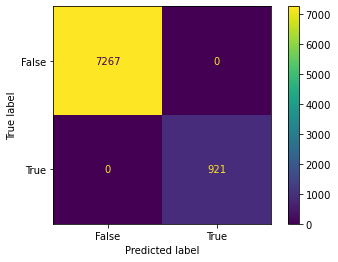

In [18]:
create_pipeline_and_run(model_knn, grid_knn);

### Run *all models* defined above

GaussianNB():
   - f1: 0.26420198376916143
   - accuracy: 0.4021978021978022
   - precision: 0.15300261096605744
   - recall: 0.966996699669967
LogisticRegression(max_iter=5000):
   - f1: 0.45673505798394287
   - accuracy: 0.7769230769230769
   - precision: 0.31295843520782396
   - recall: 0.8448844884488449
DecisionTreeClassifier():
   - f1: 0.44353741496598637
   - accuracy: 0.8501831501831502
   - precision: 0.3773148148148148
   - recall: 0.5379537953795379
RandomForestClassifier():
   - f1: 0.5018541409147095
   - accuracy: 0.8523809523809524
   - precision: 0.40118577075098816
   - recall: 0.66996699669967
KNeighborsClassifier():
   - f1: 0.5913705583756346
   - accuracy: 0.882051282051282
   - precision: 0.48041237113402063
   - recall: 0.768976897689769
AdaBoostClassifier(random_state=2021):
   - f1: 0.5641025641025641
   - accuracy: 0.8941391941391942
   - precision: 0.5194444444444445
   - recall: 0.6171617161716172
XGBClassifier(base_score=None, booster=None, colsample_bylev

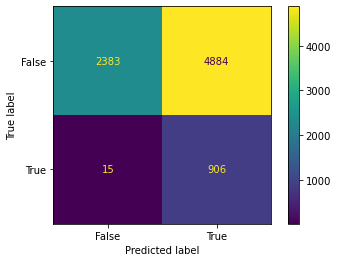

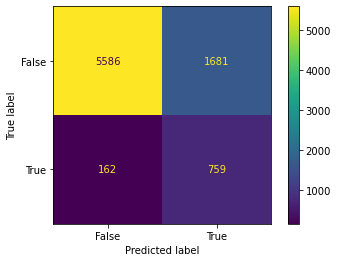

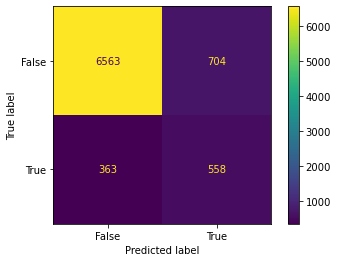

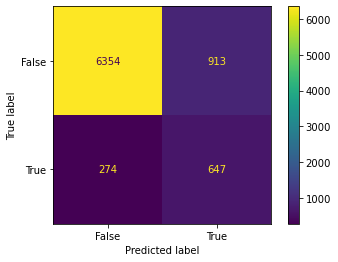

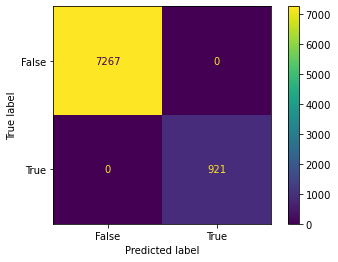

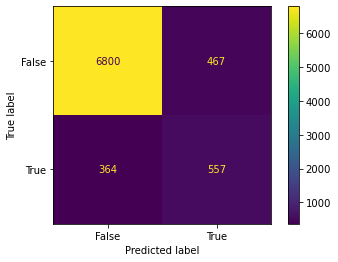

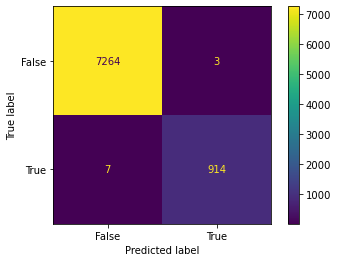

In [19]:
pipes = []
for grid, model in zip(grids, models):
    pipe = create_pipeline_and_run(model, grid)
    pipes.append(pipe)

In [20]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8188 entries, 8667 to 11633
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             8188 non-null   object 
 1   region                              8188 non-null   object 
 2   protestnumber                       8188 non-null   int64  
 3   protesterviolence                   8188 non-null   int64  
 4   duration_days                       8188 non-null   int64  
 5   participants                        8188 non-null   int64  
 6   participants_category_manufactured  8188 non-null   object 
 7   demand_labor-wage-dispute           8188 non-null   int64  
 8   demand_land-farm-issue              8188 non-null   int64  
 9   demand_police-brutality             8188 non-null   int64  
 10  demand_political-behavior/process   8188 non-null   int64  
 11  demand_price-increases/tax-policy   818